# Task 1
## Task 1.1

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

In [47]:
N = 64
r = 0.5
K = [1, 4, 8, 16]

In [48]:
def generate_coefficients(K):
    return torch.randn(K, K)

def f_u(x, y, a_ij, r):
    K = a_ij.shape[0]

    step = torch.arange(1, K+1)
    ii, jj = torch.meshgrid(step, step, indexing="ij")

    sin_ix = torch.sin(torch.pi * ii[..., None, None] * x)
    sin_jy = torch.sin(torch.pi * jj[..., None, None] * y)

    basis = sin_ix * sin_jy
    freq = ii**2 + jj**2

    f_val = (torch.pi / K**2) * torch.sum(
        a_ij[..., None, None] * freq[..., None, None]**r * basis,
        dim=(0, 1)
    )

    u_val = (1.0 / (torch.pi * K**2)) * torch.sum(
        a_ij[..., None, None] * freq[..., None, None]**(r - 1) * basis,
        dim=(0, 1)
    )

    return f_val, u_val


def generate_sample(a_ij, input=None, N=64, r=0.5):
    if input == None:
        x = torch.linspace(0, 1, N)
        y = torch.linspace(0, 1, N)
        X, Y = torch.meshgrid(x, y, indexing="ij")
        return f_u(X, Y, a_ij, r)
    else:
        x = input[:, 0:1]
        y = input[:, 1:2]
        return f_u(x, y, a_ij, r)



/var/folders/cq/6lv3lnyd7l340pjp1d_14xj80000gn/T/ipykernel_16247/4207090633.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


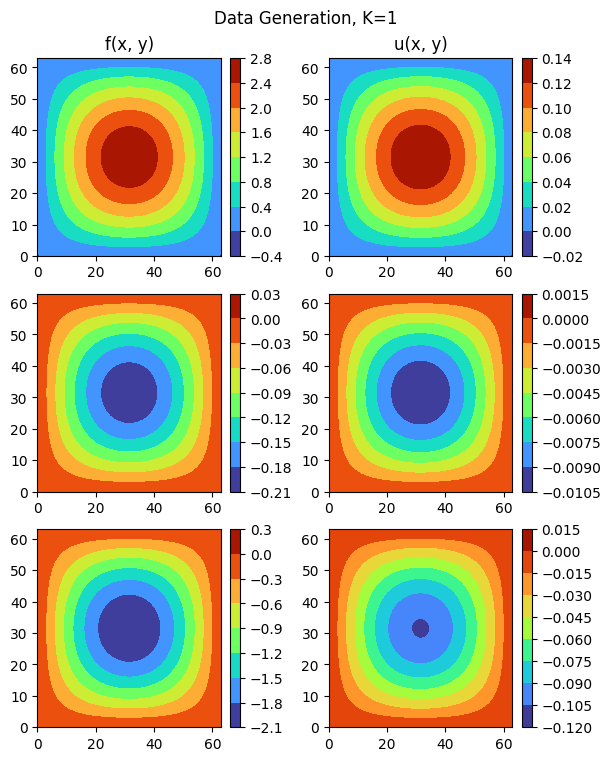

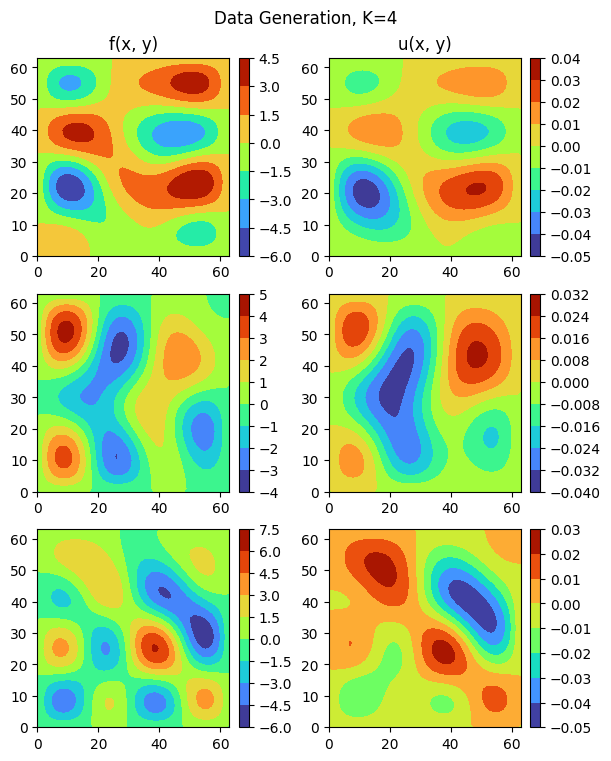

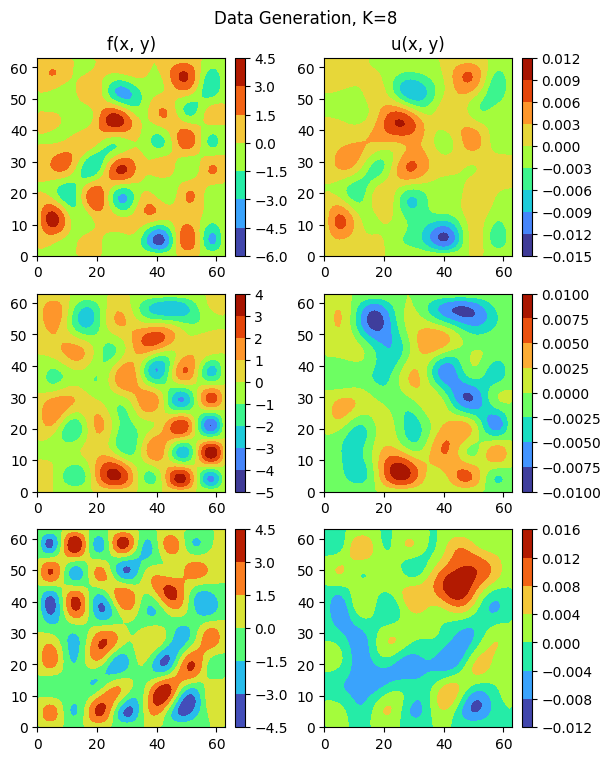

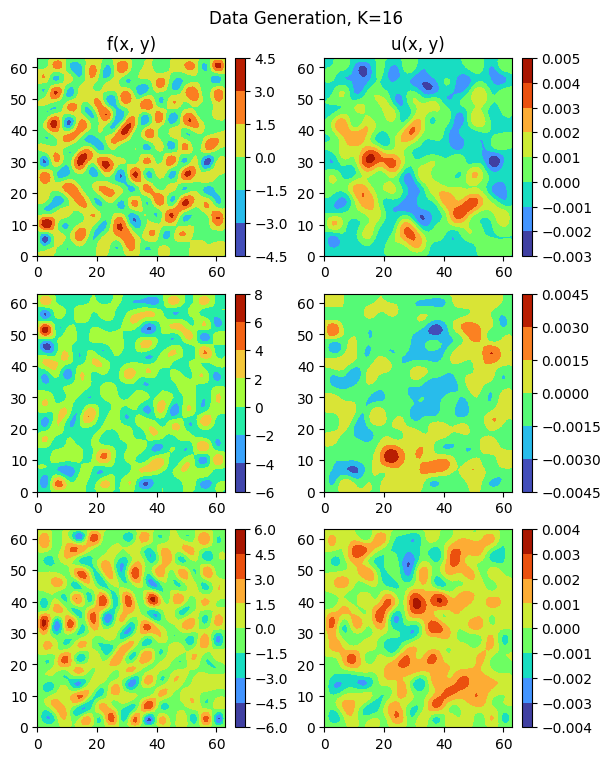

In [49]:
for i in K:
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(3*2, 2.5*3), layout="constrained")

    ax[0, 0].set_title("f(x, y)")
    ax[0, 1].set_title("u(x, y)")
    
    for j in range(3):
        a_ij = generate_coefficients(i)
        f, g = generate_sample(a_ij)
        cf0 = ax[j, 0].contourf(f, cmap="turbo")
        cf1 = ax[j, 1].contourf(g, cmap="turbo")
        fig.colorbar(cf0, ax=ax[j, 0])
        fig.colorbar(cf1, ax=ax[j, 1])
        fig.suptitle('Data Generation, K=' + str(i))
        fig.show()

## Task 1.2

### Model

In [50]:
class MLP(nn.Module):
    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.input_layer = nn.Linear(input_dimension, neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(neurons, neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(neurons, output_dimension)


    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for _, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)
    
    # def get_loss_function(self):

    # def get_optimizer(optimizer_name, model):
    #     if optimizer_name == "ADAM":
    #         return optim.Adam(model.parameters())
    #     elif optimizer_name == "LBFGS":
    #         return optim.LBFGS(model.parameters())
    #     raise ValueError('Chosen optimizer is unavailable.')
    
    # def train(model, optimizer, criterion, inputs, targets):
    #     def closure():
    #         optimizer.zero_grad()
    #         outputs = model(inputs)
    #         loss = criterion(outputs, targets)
    #         loss.backward()
    #         return loss

    #     optimizer.step(closure)
    #     return closure().item()

    # def evaluate(model, x_test):
    #     model.eval()
    #     with torch.no_grad():
    #         y_pred = model(x_test.view(-1, 1)).numpy()
    #     return y_pred
            

### PINN

In [51]:
class Pinns:
    def __init__(self, n_int_, n_bc_, resolution=1, N=64, coeff=None):
        self.n_int = n_int_
        self.n_bc = n_bc_
        self.resolution = resolution
        self.N = N
        self.lambda_u = 1
        self.domain_extrema = torch.tensor([[0, 1],  # Space dimension
                                            [0, 1]])  
        self.approximate_solution = MLP(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=2**6) # Previously 20
        
        self.training_set_bc, self.training_set_int = self.assemble_datasets()
        if coeff == None:
            self.a_ij = generate_coefficients(self.resolution)
        else:
            self.a_ij = coeff
        self.r = 0.5

    def rhs(self, input_int):
        f, _ = generate_sample(self.a_ij, input=input_int, r=self.r)
        return f.view(-1, 1)

    def analytical_solution(self, input_int):
        _, u = generate_sample(self.a_ij, input=input_int, r=self.r)
        return u.view(-1, 1)

    def add_boundary_conditions(self):
        x = torch.rand(self.N, 1)
        y = torch.rand(self.N, 1)

        bc_x0 = torch.cat([torch.zeros_like(y), y], dim=1)
        bc_x1 = torch.cat([torch.ones_like(y), y], dim=1)
        bc_y0 = torch.cat([x, torch.zeros_like(x)], dim=1)
        bc_y1 = torch.cat([x, torch.ones_like(x)], dim=1)

        input_bc = torch.cat([bc_x0, bc_x1, bc_y0, bc_y1], dim=0)
        output_bc = torch.zeros((input_bc.shape[0], 1))

        return input_bc, output_bc

    def add_interior_points(self):
        x = torch.rand(self.N, 1)
        y = torch.rand(self.N, 1)
        input_int = torch.cat([x, y], dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    def assemble_datasets(self):
        input_bc, output_bc = self.add_boundary_conditions()
        input_int, output_int = self.add_interior_points()

        training_set_bc  = DataLoader(torch.utils.data.TensorDataset(input_bc, output_bc),   batch_size=4*self.n_bc, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int,  shuffle=False)

        return training_set_bc, training_set_int

    def apply_boundary_conditions(self, input_bc):
        u_pred_bc = self.approximate_solution(input_bc)
        return u_pred_bc

    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_xx = torch.autograd.grad(grad_u[:,0].sum(), input_int, create_graph=True)[0][:, 0]
        grad_u_yy = torch.autograd.grad(grad_u[:,1].sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xx = grad_u_xx.reshape(-1, 1)  # Force shape [Batch, 1]
        grad_u_yy = grad_u_yy.reshape(-1, 1)
        residual = -(grad_u_xx + grad_u_yy) - self.rhs(input_int)
        return residual#.reshape(-1, )

    def compute_loss(self, inp_train_bc, u_train_bc, inp_train_int, verbose=True):
        u_pred_bc = self.apply_boundary_conditions(inp_train_bc)
        r_bc = u_train_bc - u_pred_bc
        r_int = self.compute_pde_residual(inp_train_int)
        loss_bc = torch.mean(abs(r_bc) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss = self.lambda_u * (loss_bc) + loss_int
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_bc).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))
        return loss

    def compute_data_driven_loss(self, inp_train_bc, u_train_bc, input_int, verbose=True): # BUG: must consider boundary points?
        u_pred_bc = self.apply_boundary_conditions(inp_train_bc)
        approximate_sol = self.approximate_solution(input_int)
        analytical_sol = self.analytical_solution(input_int) 
        loss_bc = torch.mean((u_pred_bc - u_train_bc)**2)
        loss_int = torch.mean((approximate_sol - analytical_sol)**2)

        loss_data = loss_bc + loss_int
        
        if verbose: 
            print(f"Data-Driven Loss: {loss_data.item():.6f}")
            
        return loss_data

    def fit(self, num_epochs, optimizer, PINN=True, verbose=True):
        history = list()

        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_bc, u_train_bc), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_bc, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    if PINN == True:
                        loss = self.compute_loss(inp_train_bc, u_train_bc, inp_train_int, verbose=verbose)
                    else :
                        loss = self.compute_data_driven_loss(inp_train_bc, u_train_bc, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])


        return history

    def plot(self):
        x = torch.linspace(0, 1, self.N)
        y = torch.linspace(0, 1, self.N)
        X, Y = torch.meshgrid(x, y, indexing="ij")
        inputs = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
        with torch.no_grad():
            approximate_sol = self.approximate_solution(inputs).reshape(self.N, self.N)
            analytical_sol = self.analytical_solution(inputs).reshape(self.N, self.N)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].contourf(X, Y, analytical_sol, cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].contourf(X, Y, approximate_sol, cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((approximate_sol - analytical_sol) ** 2) / torch.mean(analytical_sol ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")

**Test for single case**

In [52]:
n_int = 256
n_bc = 64
resolution=K[1]
a_ij = generate_coefficients(resolution)

model = Pinns(n_int, n_bc, resolution=resolution)

In [53]:
optimizer_ADAM = optim.Adam(model.approximate_solution.parameters(),
                            lr=float(0.001))
optimizer_LBFGS = optim.LBFGS(model.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

--- Starting Adam ---
Final Loss:  5.852507456438616e-05
--- Starting LBFGS ---
Final Loss:  1.7614873968341271e-06


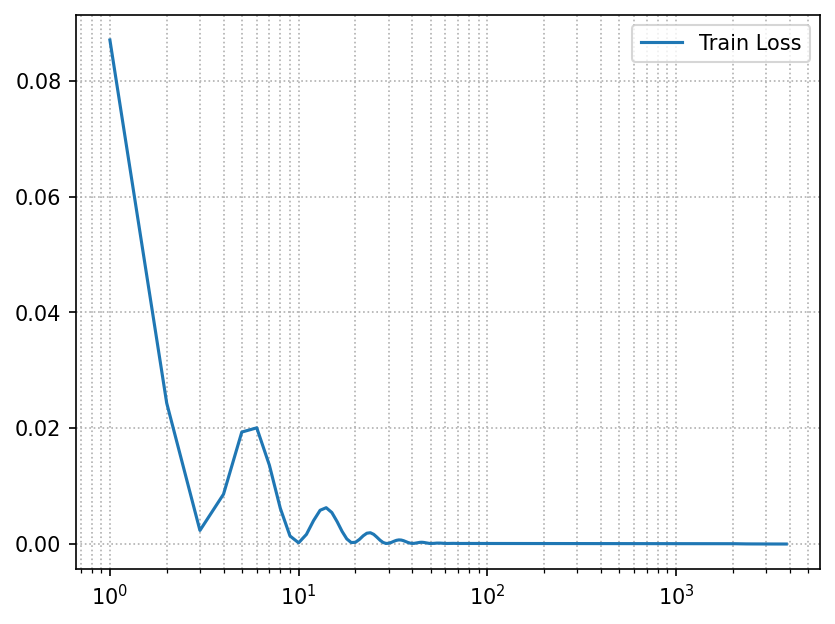

In [54]:
print("--- Starting Adam ---")
hist_adam = model.fit(num_epochs=2000, optimizer=optimizer_ADAM,  PINN=False, verbose=False)
print("--- Starting LBFGS ---")
hist_lbfgs = model.fit(num_epochs=1,   optimizer=optimizer_LBFGS, PINN=False, verbose=False)

hist = hist_adam + hist_lbfgs

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()
plt.show()

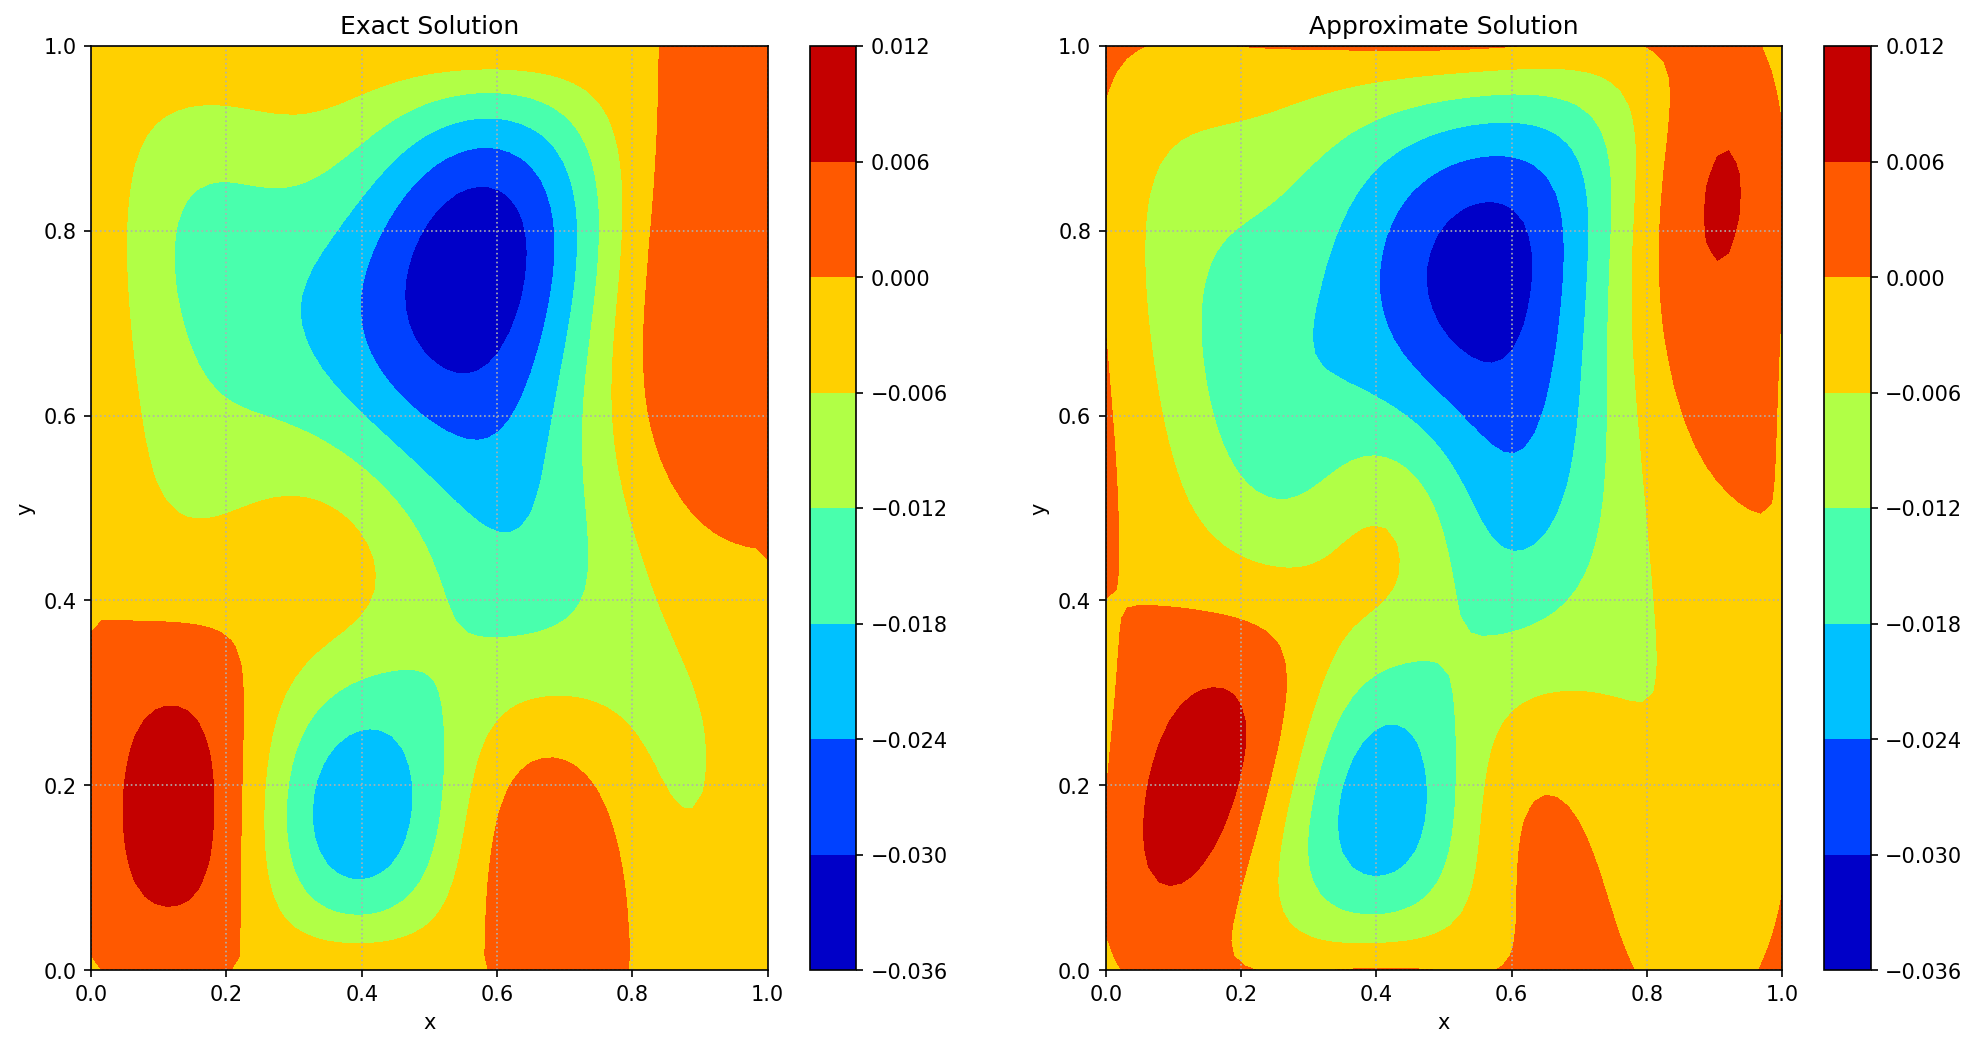

L2 Relative Error Norm:  13.109114646911621 %


In [55]:
model.plot()

**Train on multiple Ks**


===== Training PINN for K=1 =====

--- Starting Adam ---
Final Loss:  0.00019431678811088204
--- Starting LBFGS ---
Final Loss:  5.838861056872702e-07


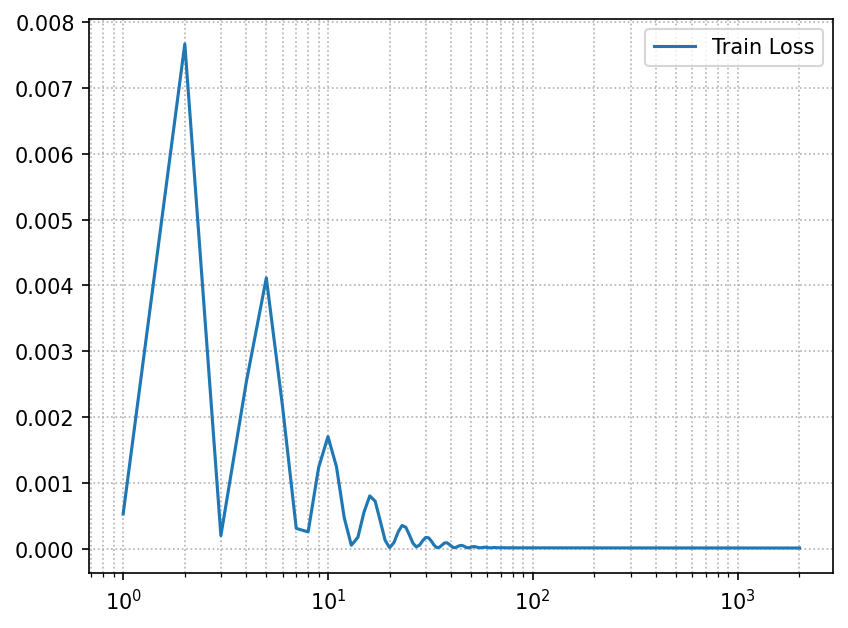

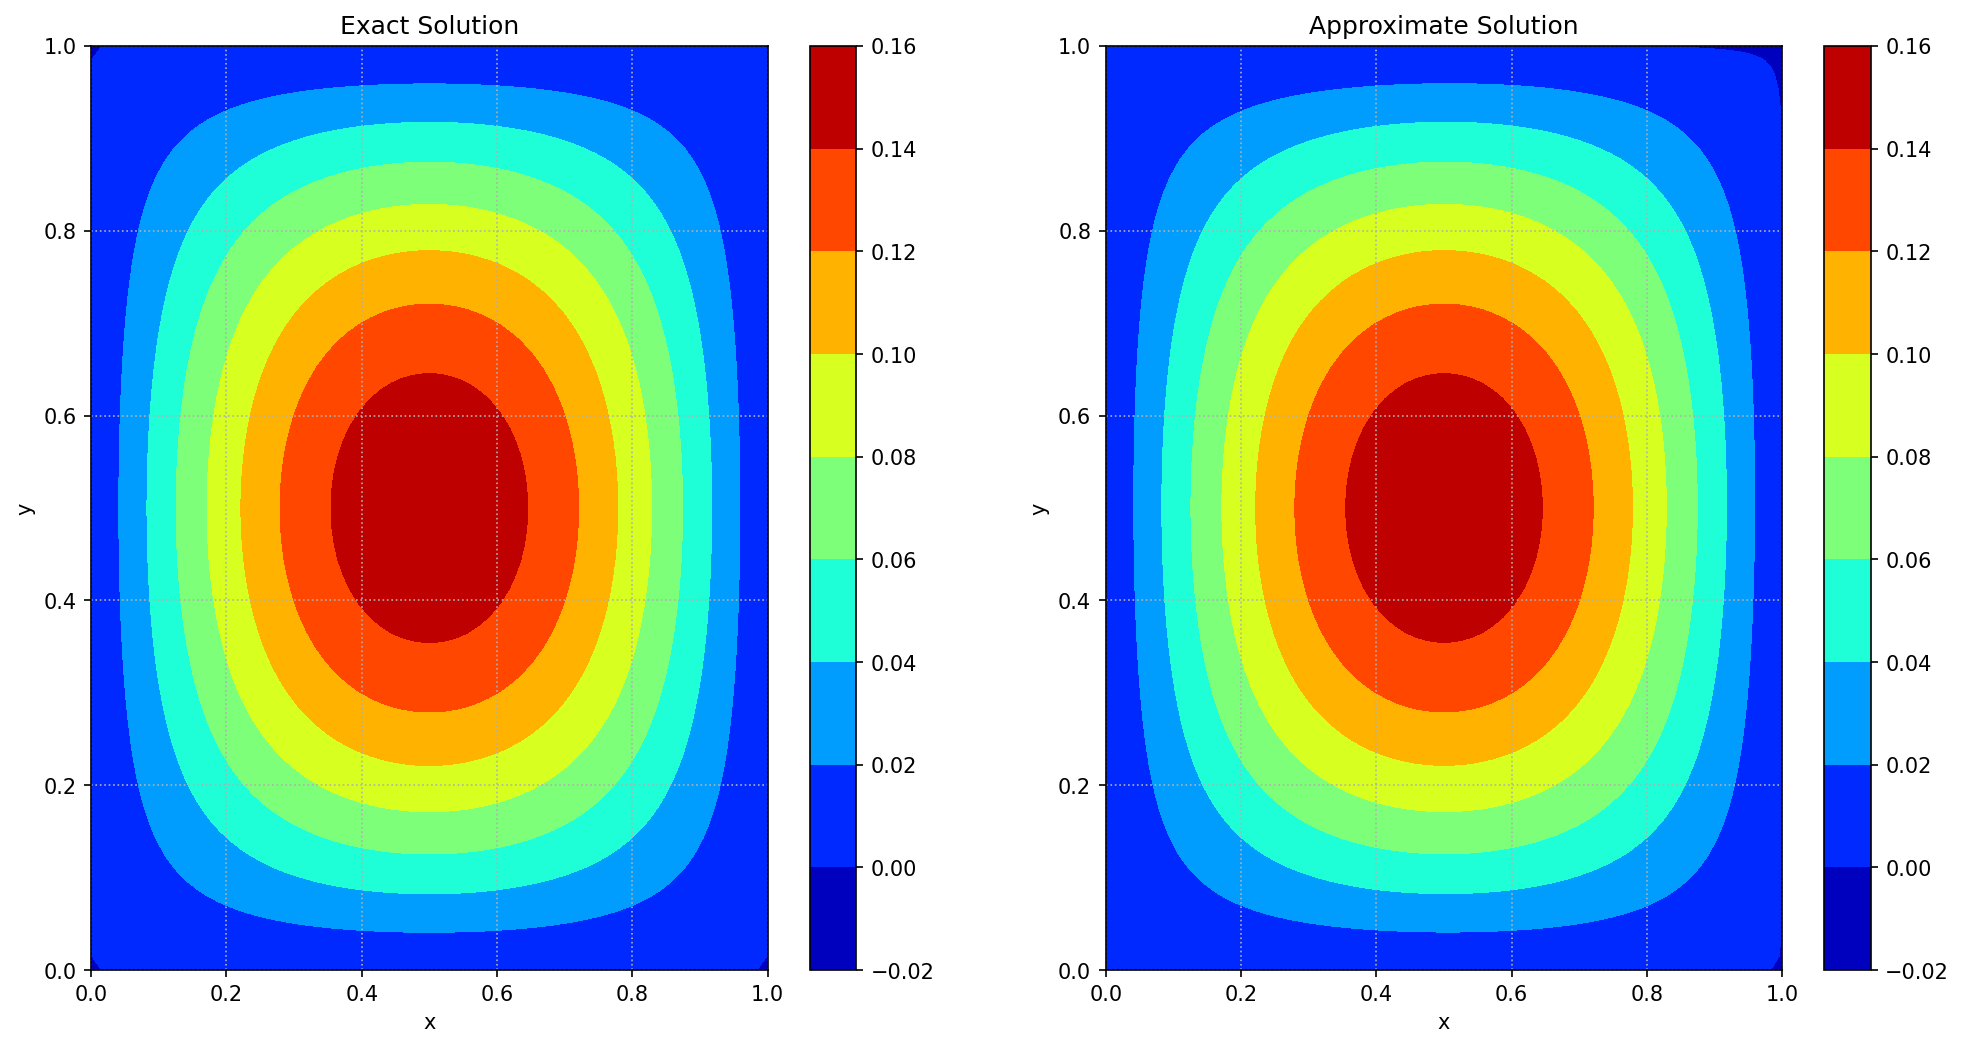

L2 Relative Error Norm:  0.20323188602924347 %
--- Starting Adam ---
Final Loss:  1.4169467249303125e-05
--- Starting LBFGS ---


KeyboardInterrupt: 

In [ ]:
pinn = True

for k in K:
    print(f"\n===== Training PINN for K={k} =====\n")

    # FIX coefficients ONCE (reuse from Task 1.1 if you want)
    a_ij = generate_coefficients(k)

    model = Pinns(n_int, n_bc, resolution=k, coeff=a_ij, N=64)

    optimizer_ADAM = optim.Adam(model.approximate_solution.parameters(),
                                lr=float(0.001))
    optimizer_LBFGS = optim.LBFGS(model.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

    print("--- Starting Adam ---")
    hist_adam = model.fit(num_epochs=2000, optimizer=optimizer_ADAM,  PINN=pinn, verbose=False)
    print("--- Starting LBFGS ---")
    hist_lbfgs = model.fit(num_epochs=1,   optimizer=optimizer_LBFGS, PINN=pinn, verbose=False)

    hist_pinn = hist_adam + hist_lbfgs

    model.plot()

    model = Pinns(n_int, n_bc, resolution=k, coeff=a_ij, N=64)

    optimizer_ADAM = optim.Adam(model.approximate_solution.parameters(),
                                lr=float(0.001))
    optimizer_LBFGS = optim.LBFGS(model.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

    print("--- Starting Adam ---")
    hist_adam = model.fit(num_epochs=2000, optimizer=optimizer_ADAM,  PINN=False, verbose=False)
    print("--- Starting LBFGS ---")
    hist_lbfgs = model.fit(num_epochs=1,   optimizer=optimizer_LBFGS, PINN=False, verbose=False)

    hist_dd = hist_adam + hist_lbfgs

    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist_pinn) + 1), hist_pinn, label="PINN Loss")
    plt.plot(np.arange(1, len(hist_dd) + 1), hist_dd, label="Data-driven Loss")
    plt.xscale("log")
    plt.legend()
    plt.show()
    model.plot()
